# Home Credit Default Risk 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
from lightgbm import LGBMClassifier

In [4]:
from scipy.stats import ranksums

In [6]:
from bayes_opt import BayesianOptimization

## Aggregating datasets

### Service functions

In [7]:
def reduce_mem_usage(data, verbose = True):
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

In [8]:
def one_hot_encoder(data, nan_as_category = True):
    original_columns = list(data.columns)
    categorical_columns = [col for col in data.columns \
                           if not pd.api.types.is_numeric_dtype(data[col].dtype)]
    for c in categorical_columns:
        if nan_as_category:
            data[c].fillna('NaN', inplace = True)
        values = list(data[c].unique())
        for v in values:
            data[str(c) + '_' + str(v)] = (data[c] == v).astype(np.uint8)
    data.drop(categorical_columns, axis = 1, inplace = True)
    return data, [c for c in data.columns if c not in original_columns]

### Aggregating functions

In [9]:
file_path = './input/'

In [10]:
def application_train_test(file_path = file_path, nan_as_category = True):
    # Read data and merge
    df_train = pd.read_csv(file_path + 'application_train.csv')
    df_test = pd.read_csv(file_path + 'application_test.csv')
    df = pd.concat([df_train, df_test], axis = 0, ignore_index = True)
    del df_train, df_test
    gc.collect()
    
    # Remove some rows with values not present in test set
    df.drop(df[df['CODE_GENDER'] == 'XNA'].index, inplace = True)
    df.drop(df[df['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace = True)
    df.drop(df[df['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace = True)
    
    # Remove some empty features
    df.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)
    
    # Replace some outliers
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    df.loc[df['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
    df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
    df.loc[df['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
    df.loc[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df, _ = one_hot_encoder(df, nan_as_category)
    
    # Some new features
    df['app missing'] = df.isnull().sum(axis = 1).values
    
    df['app EXT_SOURCE mean'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    df['app EXT_SOURCE std'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
    df['app EXT_SOURCE prod'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['app EXT_SOURCE_1 * EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_2 / DAYS_BIRTH'] = df['EXT_SOURCE_2'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_3 / DAYS_BIRTH'] = df['EXT_SOURCE_3'] / df['DAYS_BIRTH']
    
    df['app AMT_CREDIT - AMT_GOODS_PRICE'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_ANNUITY'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['app AMT_CREDIT / AMT_INCOME_TOTAL'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
    df['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    
    df['app most popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'] \
                        .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
    df['app popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'] \
                        .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})
    
    df['app OWN_CAR_AGE / DAYS_BIRTH'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['app OWN_CAR_AGE / DAYS_EMPLOYED'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['app DAYS_EMPLOYED - DAYS_BIRTH'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']
    df['app DAYS_EMPLOYED / DAYS_BIRTH'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    df['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
    
    return reduce_mem_usage(df)

In [11]:
def bureau_and_balance(file_path = file_path, nan_as_category = True):
    df_bureau_b = reduce_mem_usage(pd.read_csv(file_path + 'bureau_balance.csv'), verbose = False)
    
    # Some new features in bureau_balance set
    tmp = df_bureau_b[['SK_ID_BUREAU', 'STATUS']].groupby('SK_ID_BUREAU')
    tmp_last = tmp.last()
    tmp_last.columns = ['First_status']
    df_bureau_b = df_bureau_b.join(tmp_last, how = 'left', on = 'SK_ID_BUREAU')
    tmp_first = tmp.first()
    tmp_first.columns = ['Last_status']
    df_bureau_b = df_bureau_b.join(tmp_first, how = 'left', on = 'SK_ID_BUREAU')
    del tmp, tmp_first, tmp_last
    gc.collect()
    
    tmp = df_bureau_b[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').last()
    tmp = tmp.apply(abs)
    tmp.columns = ['Month']
    df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
    del tmp
    gc.collect()
    
    tmp = df_bureau_b.loc[df_bureau_b['STATUS'] == 'C', ['SK_ID_BUREAU', 'MONTHS_BALANCE']] \
                .groupby('SK_ID_BUREAU').last()
    tmp = tmp.apply(abs)
    tmp.columns = ['When_closed']
    df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
    del tmp
    gc.collect()
    
    df_bureau_b['Month_closed_to_end'] = df_bureau_b['Month'] - df_bureau_b['When_closed']

    for c in range(6):
        tmp = df_bureau_b.loc[df_bureau_b['STATUS'] == str(c), ['SK_ID_BUREAU', 'MONTHS_BALANCE']] \
                         .groupby('SK_ID_BUREAU').count()
        tmp.columns = ['DPD_' + str(c) + '_cnt']
        df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
        df_bureau_b['DPD_' + str(c) + ' / Month'] = df_bureau_b['DPD_' + str(c) + '_cnt'] / df_bureau_b['Month']
        del tmp
        gc.collect()
    df_bureau_b['Non_zero_DPD_cnt'] = df_bureau_b[['DPD_1_cnt', 'DPD_2_cnt', 'DPD_3_cnt', 'DPD_4_cnt', 'DPD_5_cnt']].sum(axis = 1)
    
    df_bureau_b, bureau_b_cat = one_hot_encoder(df_bureau_b, nan_as_category)

    # Bureau balance: Perform aggregations 
    aggregations = {}
    for col in df_bureau_b.columns:
        aggregations[col] = ['mean'] if col in bureau_b_cat else ['min', 'max', 'size']
    df_bureau_b_agg = df_bureau_b.groupby('SK_ID_BUREAU').agg(aggregations)
    df_bureau_b_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df_bureau_b_agg.columns.tolist()])
    del df_bureau_b
    gc.collect()

    df_bureau = reduce_mem_usage(pd.read_csv(file_path + 'bureau.csv'), verbose = False)
                  
    # Replace\remove some outliers in bureau set
    df_bureau.loc[df_bureau['AMT_ANNUITY'] > .8e8, 'AMT_ANNUITY'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_SUM'] > 3e8, 'AMT_CREDIT_SUM'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_SUM_DEBT'] > 1e8, 'AMT_CREDIT_SUM_DEBT'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_MAX_OVERDUE'] > .8e8, 'AMT_CREDIT_MAX_OVERDUE'] = np.nan
    df_bureau.loc[df_bureau['DAYS_ENDDATE_FACT'] < -10000, 'DAYS_ENDDATE_FACT'] = np.nan
    df_bureau.loc[(df_bureau['DAYS_CREDIT_UPDATE'] > 0) | (df_bureau['DAYS_CREDIT_UPDATE'] < -40000), 'DAYS_CREDIT_UPDATE'] = np.nan
    df_bureau.loc[df_bureau['DAYS_CREDIT_ENDDATE'] < -10000, 'DAYS_CREDIT_ENDDATE'] = np.nan
    
    df_bureau.drop(df_bureau[df_bureau['DAYS_ENDDATE_FACT'] < df_bureau['DAYS_CREDIT']].index, inplace = True)
    
    # Some new features in bureau set
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_DEBT']
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_LIMIT']
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_OVERDUE']

    df_bureau['bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE'] = df_bureau['DAYS_CREDIT'] - df_bureau['CREDIT_DAY_OVERDUE']
    df_bureau['bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_CREDIT_ENDDATE']
    df_bureau['bureau DAYS_CREDIT - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT_ENDDATE'] - df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_UPDATE - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT_UPDATE'] - df_bureau['DAYS_CREDIT_ENDDATE']
    
    # Categorical features with One-Hot encode
    df_bureau, bureau_cat = one_hot_encoder(df_bureau, nan_as_category)
    
    # Bureau balance: merge with bureau.csv
    df_bureau = df_bureau.join(df_bureau_b_agg, how = 'left', on = 'SK_ID_BUREAU')
    df_bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True)
    del df_bureau_b_agg
    gc.collect()
    
    # Bureau and bureau_balance aggregations for application set
    categorical = bureau_cat + bureau_b_cat
    aggregations = {}
    for col in df_bureau.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_bureau_agg = df_bureau.groupby('SK_ID_CURR').agg(aggregations)
    df_bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in df_bureau_agg.columns.tolist()])
    
    # Bureau: Active credits
    active_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Active'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(active_agg, how = 'left')
    del active_agg
    gc.collect()
    
    # Bureau: Closed credits
    closed_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Closed'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(closed_agg, how = 'left')
    del closed_agg, df_bureau
    gc.collect()
    
    return reduce_mem_usage(df_bureau_agg)

In [12]:
def previous_application(file_path = file_path, nan_as_category = True):
    df_prev = pd.read_csv(file_path + 'previous_application.csv')
    
    # Replace some outliers
    df_prev.loc[df_prev['AMT_CREDIT'] > 6000000, 'AMT_CREDIT'] = np.nan
    df_prev.loc[df_prev['SELLERPLACE_AREA'] > 3500000, 'SELLERPLACE_AREA'] = np.nan
    df_prev[['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
             'DAYS_LAST_DUE', 'DAYS_TERMINATION']].replace(365243, np.nan, inplace = True)
    
    # Some new features
    df_prev['prev missing'] = df_prev.isnull().sum(axis = 1).values
    df_prev['prev AMT_APPLICATION / AMT_CREDIT'] = df_prev['AMT_APPLICATION'] / df_prev['AMT_CREDIT']
    df_prev['prev AMT_APPLICATION - AMT_CREDIT'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_CREDIT']
    df_prev['prev AMT_APPLICATION - AMT_GOODS_PRICE'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_GOODS_PRICE']
    df_prev['prev AMT_GOODS_PRICE - AMT_CREDIT'] = df_prev['AMT_GOODS_PRICE'] - df_prev['AMT_CREDIT']
    df_prev['prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE'] = df_prev['DAYS_FIRST_DRAWING'] - df_prev['DAYS_FIRST_DUE']
    df_prev['prev DAYS_TERMINATION less -500'] = (df_prev['DAYS_TERMINATION'] < -500).astype(int)
    
    # Categorical features with One-Hot encode
    df_prev, categorical = one_hot_encoder(df_prev, nan_as_category)

    # Aggregations for application set
    aggregations = {}
    for col in df_prev.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_prev_agg = df_prev.groupby('SK_ID_CURR').agg(aggregations)
    df_prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df_prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications
    approved_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Approved'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(approved_agg, how = 'left')
    del approved_agg
    gc.collect()
    
    # Previous Applications: Refused Applications
    refused_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Refused'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(refused_agg, how = 'left')
    del refused_agg, df_prev
    gc.collect()
    
    return reduce_mem_usage(df_prev_agg)

In [13]:
def pos_cash(file_path = file_path, nan_as_category = True):
    df_pos = pd.read_csv(file_path + 'POS_CASH_balance.csv')
    
    # Replace some outliers
    df_pos.loc[df_pos['CNT_INSTALMENT_FUTURE'] > 60, 'CNT_INSTALMENT_FUTURE'] = np.nan
    
    # Some new features
    df_pos['pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE'] = \
                    (df_pos['CNT_INSTALMENT'] > df_pos['CNT_INSTALMENT_FUTURE']).astype(int)
    
    # Categorical features with One-Hot encode
    df_pos, categorical = one_hot_encoder(df_pos, nan_as_category)
    
    # Aggregations for application set
    aggregations = {}
    for col in df_pos.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_pos_agg = df_pos.groupby('SK_ID_CURR').agg(aggregations)
    df_pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in df_pos_agg.columns.tolist()])

    # Count POS lines
    df_pos_agg['POS_COUNT'] = df_pos.groupby('SK_ID_CURR').size()
    del df_pos
    gc.collect()
    
    return reduce_mem_usage(df_pos_agg)

In [14]:
def installments_payments(file_path = file_path, nan_as_category = True):
    df_ins = pd.read_csv(file_path + 'installments_payments.csv')
    
    # Replace some outliers
    df_ins.loc[df_ins['NUM_INSTALMENT_VERSION'] > 70, 'NUM_INSTALMENT_VERSION'] = np.nan
    df_ins.loc[df_ins['DAYS_ENTRY_PAYMENT'] < -4000, 'DAYS_ENTRY_PAYMENT'] = np.nan
    
    # Some new features
    df_ins['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = df_ins['DAYS_ENTRY_PAYMENT'] - df_ins['DAYS_INSTALMENT']
    df_ins['ins NUM_INSTALMENT_NUMBER_100'] = (df_ins['NUM_INSTALMENT_NUMBER'] == 100).astype(int)
    df_ins['ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER'] = (df_ins['DAYS_INSTALMENT'] > df_ins['NUM_INSTALMENT_NUMBER'] * 50 / 3 - 11500 / 3).astype(int)
    df_ins['ins AMT_INSTALMENT - AMT_PAYMENT'] = df_ins['AMT_INSTALMENT'] - df_ins['AMT_PAYMENT']
    df_ins['ins AMT_PAYMENT / AMT_INSTALMENT'] = df_ins['AMT_PAYMENT'] / df_ins['AMT_INSTALMENT']
    
    # Categorical features with One-Hot encode
    df_ins, categorical = one_hot_encoder(df_ins, nan_as_category)

    # Aggregations for application set
    aggregations = {}
    for col in df_ins.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_ins_agg = df_ins.groupby('SK_ID_CURR').agg(aggregations)
    df_ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in df_ins_agg.columns.tolist()])
    
    # Count installments lines
    df_ins_agg['INSTAL_COUNT'] = df_ins.groupby('SK_ID_CURR').size()
    del df_ins
    gc.collect()
    
    return reduce_mem_usage(df_ins_agg)

In [15]:
def credit_card_balance(file_path = file_path, nan_as_category = True):
    df_card = pd.read_csv(file_path + 'credit_card_balance.csv')
    
    # Replace some outliers
    df_card.loc[df_card['AMT_PAYMENT_CURRENT'] > 4000000, 'AMT_PAYMENT_CURRENT'] = np.nan
    df_card.loc[df_card['AMT_CREDIT_LIMIT_ACTUAL'] > 1000000, 'AMT_CREDIT_LIMIT_ACTUAL'] = np.nan

    # Some new features
    df_card['card missing'] = df_card.isnull().sum(axis = 1).values
    df_card['card SK_DPD - MONTHS_BALANCE'] = df_card['SK_DPD'] - df_card['MONTHS_BALANCE']
    df_card['card SK_DPD_DEF - MONTHS_BALANCE'] = df_card['SK_DPD_DEF'] - df_card['MONTHS_BALANCE']
    df_card['card SK_DPD - SK_DPD_DEF'] = df_card['SK_DPD'] - df_card['SK_DPD_DEF']
    
    df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECIVABLE']
    df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
    df_card['card AMT_RECIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_RECIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']

    df_card['card AMT_BALANCE - AMT_RECIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_RECIVABLE']
    df_card['card AMT_BALANCE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_BALANCE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
    df_card['card AMT_BALANCE - AMT_TOTAL_RECEIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_TOTAL_RECEIVABLE']

    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_ATM_CURRENT']
    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_OTHER_CURRENT']
    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_POS_CURRENT']
    
    # Categorical features with One-Hot encode
    df_card, categorical = one_hot_encoder(df_card, nan_as_category)
    
    # Aggregations for application set
    aggregations = {}
    for col in df_card.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_card_agg = df_card.groupby('SK_ID_CURR').agg(aggregations)
    df_card_agg.columns = pd.Index(['CARD_' + e[0] + "_" + e[1].upper() for e in df_card_agg.columns.tolist()])

    # Count credit card lines
    df_card_agg['CARD_COUNT'] = df_card.groupby('SK_ID_CURR').size()
    del df_card
    gc.collect()
    
    return reduce_mem_usage(df_card_agg)

In [16]:
def aggregate(file_path = file_path):
    warnings.simplefilter(action = 'ignore')
    
    print('-' * 20)
    print('1: application train & test (', time.ctime(), ')')
    print('-' * 20)
    df = application_train_test(file_path)
    print('     DF shape:', df.shape)
    
    print('-' * 20)
    print('2: bureau & balance (', time.ctime(), ')')
    print('-' * 20)
    bureau = bureau_and_balance(file_path)
    df = df.join(bureau, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del bureau
    gc.collect()
    
    print('-' * 20)
    print('3: previous_application (', time.ctime(), ')')
    print('-' * 20)
    prev = previous_application(file_path)
    df = df.join(prev, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del prev
    gc.collect()
    
    print('-' * 20)
    print('4: POS_CASH_balance (', time.ctime(), ')')
    print('-' * 20)
    pos = pos_cash(file_path)
    df = df.join(pos, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del pos
    gc.collect()
    
    print('-' * 20)
    print('5: installments_payments (', time.ctime(), ')')
    print('-' * 20)
    ins = installments_payments(file_path)
    df = df.join(ins, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del ins
    gc.collect()
    
    print('-' * 20)
    print('6: credit_card_balance (', time.ctime(), ')')
    print('-' * 20)
    cc = credit_card_balance(file_path)
    df = df.join(cc, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del cc
    gc.collect()
    
    print('-' * 20)
    print('7: final dataset (', time.ctime(), ')')
    print('-' * 20)
    return reduce_mem_usage(df)

In [17]:
# Kaggle has not ehough memory to clean this dataset
# Aggregated dataset has 3411 features

df = aggregate()

--------------------
1: application train & test ( Wed Aug  8 19:52:17 2018 )
--------------------
Memory usage of dataframe: 399.87 MB
Memory usage after optimization: 182.10 MB
Decreased by 54.5%
     DF shape: (356244, 266)
--------------------
2: bureau & balance ( Wed Aug  8 19:52:30 2018 )
--------------------
Memory usage of dataframe: 4036.72 MB
Memory usage after optimization: 1292.65 MB
Decreased by 68.0%
     DF shape: (356244, 2117)
--------------------
3: previous_application ( Wed Aug  8 19:57:13 2018 )
--------------------
Memory usage of dataframe: 2440.16 MB
Memory usage after optimization: 832.12 MB
Decreased by 65.9%
     DF shape: (356244, 3056)
--------------------
4: POS_CASH_balance ( Wed Aug  8 19:58:41 2018 )
--------------------
Memory usage of dataframe: 151.81 MB
Memory usage after optimization: 46.96 MB
Decreased by 69.1%
     DF shape: (356244, 3114)
--------------------
5: installments_payments ( Wed Aug  8 19:59:05 2018 )
--------------------
Memory usag

## Cleaning dataset

In [18]:
def corr_feature_with_target(feature, target):
    c0 = feature[target == 0].dropna()
    c1 = feature[target == 1].dropna()
        
    if set(feature.unique()) == set([0, 1]):
        diff = abs(c0.mean(axis = 0) - c1.mean(axis = 0))
    else:
        diff = abs(c0.median(axis = 0) - c1.median(axis = 0))
        
    p = ranksums(c0, c1)[1] if ((len(c0) >= 20) & (len(c1) >= 20)) else 2
        
    return [diff, p]

In [19]:
def clean_data(data):
    warnings.simplefilter(action = 'ignore')
    
    # Removing empty features
    nun = data.nunique()
    empty = list(nun[nun <= 1].index)
    
    data.drop(empty, axis = 1, inplace = True)
    print('After removing empty features there are {0:d} features'.format(data.shape[1]))
    
    # Removing features with the same distribution on 0 and 1 classes
    corr = pd.DataFrame(index = ['diff', 'p'])
    ind = data[data['TARGET'].notnull()].index
    
    for c in data.columns.drop('TARGET'):
        corr[c] = corr_feature_with_target(data.loc[ind, c], data.loc[ind, 'TARGET'])

    corr = corr.T
    corr['diff_norm'] = abs(corr['diff'] / data.mean(axis = 0))
    
    to_del_1 = corr[((corr['diff'] == 0) & (corr['p'] > .05))].index
    to_del_2 = corr[((corr['diff_norm'] < .5) & (corr['p'] > .05))].drop(to_del_1).index
    to_del = list(to_del_1) + list(to_del_2)
    if 'SK_ID_CURR' in to_del:
        to_del.remove('SK_ID_CURR')
        
    data.drop(to_del, axis = 1, inplace = True)
    print('After removing features with the same distribution on 0 and 1 classes there are {0:d} features'.format(data.shape[1]))
    
    # Removing features with not the same distribution on train and test datasets
    corr_test = pd.DataFrame(index = ['diff', 'p'])
    target = data['TARGET'].notnull().astype(int)
    
    for c in data.columns.drop('TARGET'):
        corr_test[c] = corr_feature_with_target(data[c], target)

    corr_test = corr_test.T
    corr_test['diff_norm'] = abs(corr_test['diff'] / data.mean(axis = 0))
    
    bad_features = corr_test[((corr_test['p'] < .05) & (corr_test['diff_norm'] > 1))].index
    bad_features = corr.loc[bad_features][corr['diff_norm'] == 0].index
    
    data.drop(bad_features, axis = 1, inplace = True)
    print('After removing features with not the same distribution on train and test datasets there are {0:d} features'.format(data.shape[1]))
    
    del corr, corr_test
    gc.collect()
    
    # Removing features not interesting for classifier
    clf = LGBMClassifier(random_state = 0)
    train_index = data[data['TARGET'].notnull()].index
    train_columns = data.drop('TARGET', axis = 1).columns

    score = 1
    new_columns = []
    while score > .7:
        train_columns = train_columns.drop(new_columns)
        clf.fit(data.loc[train_index, train_columns], data.loc[train_index, 'TARGET'])
        f_imp = pd.Series(clf.feature_importances_, index = train_columns)
        score = roc_auc_score(data.loc[train_index, 'TARGET'], 
                              clf.predict_proba(data.loc[train_index, train_columns])[:, 1])
        new_columns = f_imp[f_imp > 0].index

    data.drop(train_columns, axis = 1, inplace = True)
    print('After removing features not interesting for classifier there are {0:d} features'.format(data.shape[1]))

    return data

In [20]:
# Kaggle has not ehough memory to run this code - more than 14 Gb RAM

# Dataset for cleaning has 3411 features
# After removing empty features there are 3289 features
# After removing features with the same distribution on 0 and 1 classes there are 2171 features
# After removing features with not the same distribution on train and test datasets there are 2115 features
# After removing features not interesting for classifier there are 1505 features

df = clean_data(df)

After removing empty features there are 3289 features
After removing features with the same distribution on 0 and 1 classes there are 2171 features
After removing features with not the same distribution on train and test datasets there are 2115 features
After removing features not interesting for classifier there are 1505 features


## Optimization LGBM parameters

### Optimization and visualisation functions

In [21]:
def cv_scores(df, num_folds, params, stratified = True, verbose = -1, 
              save_train_prediction = False, train_prediction_file_name = 'train_prediction.csv',
              save_test_prediction = True, test_prediction_file_name = 'test_prediction.csv'):
    warnings.simplefilter('ignore')
    
    clf = LGBMClassifier(**params)

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    else:
        folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
        
    # Create arrays and dataframes to store results
    train_pred = np.zeros(train_df.shape[0])
    train_pred_proba = np.zeros(train_df.shape[0])

    test_pred = np.zeros(train_df.shape[0])
    test_pred_proba = np.zeros(train_df.shape[0])
    
    prediction = np.zeros(test_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    df_feature_importance = pd.DataFrame(index = feats)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print('Fold', n_fold, 'started at', time.ctime())
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = verbose, early_stopping_rounds = 200)

        train_pred[train_idx] = clf.predict(train_x, num_iteration = clf.best_iteration_)
        train_pred_proba[train_idx] = clf.predict_proba(train_x, num_iteration = clf.best_iteration_)[:, 1]
        test_pred[valid_idx] = clf.predict(valid_x, num_iteration = clf.best_iteration_)
        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        prediction += \
                clf.predict_proba(test_df[feats], num_iteration = clf.best_iteration_)[:, 1] / folds.n_splits

        df_feature_importance[n_fold] = pd.Series(clf.feature_importances_, index = feats)
        
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc_score(valid_y, test_pred_proba[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    roc_auc_train = roc_auc_score(train_df['TARGET'], train_pred_proba)
    precision_train = precision_score(train_df['TARGET'], train_pred, average = None)
    recall_train = recall_score(train_df['TARGET'], train_pred, average = None)
    
    roc_auc_test = roc_auc_score(train_df['TARGET'], test_pred_proba)
    precision_test = precision_score(train_df['TARGET'], test_pred, average = None)
    recall_test = recall_score(train_df['TARGET'], test_pred, average = None)

    print('Full AUC score %.6f' % roc_auc_test)
    
    df_feature_importance.fillna(0, inplace = True)
    df_feature_importance['mean'] = df_feature_importance.mean(axis = 1)
    
    # Write prediction files
    if save_train_prediction:
        df_prediction = train_df[['SK_ID_CURR', 'TARGET']]
        df_prediction['Prediction'] = test_pred_proba
        df_prediction.to_csv(train_prediction_file_name, index = False)
        del df_prediction
        gc.collect()

    if save_test_prediction:
        df_prediction = test_df[['SK_ID_CURR']]
        df_prediction['TARGET'] = prediction
        df_prediction.to_csv(test_prediction_file_name, index = False)
        del df_prediction
        gc.collect()
    
    return df_feature_importance, \
           [roc_auc_train, roc_auc_test,
            precision_train[0], precision_test[0], precision_train[1], precision_test[1],
            recall_train[0], recall_test[0], recall_train[1], recall_test[1], 0]

In [22]:
def display_folds_importances(feature_importance_df_, n_folds = 5):
    n_columns = 3
    n_rows = (n_folds + 1) // n_columns
    _, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 8 * n_rows))
    for i in range(n_folds):
        sns.barplot(x = i, y = 'index', data = feature_importance_df_.reset_index().sort_values(i, ascending = False).head(20), 
                    ax = axes[i // n_columns, i % n_columns])
    sns.barplot(x = 'mean', y = 'index', data = feature_importance_df_.reset_index().sort_values('mean', ascending = False).head(20), 
                    ax = axes[n_rows - 1, n_columns - 1])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

### Table for scores

In [23]:
scores_index = [
    'roc_auc_train', 'roc_auc_test', 
    'precision_train_0', 'precision_test_0', 
    'precision_train_1', 'precision_test_1', 
    'recall_train_0', 'recall_test_0', 
    'recall_train_1', 'recall_test_1', 
    'LB'
]

scores = pd.DataFrame(index = scores_index)

In [24]:

lgbm_params = {
            'nthread': 15,
            'n_estimators': 10000,
            'learning_rate': .02,
            'num_leaves': 34,
            'colsample_bytree': .9497036,
            'subsample': .8715623,
            'max_depth': 8,
            'reg_alpha': .041545473,
            'reg_lambda': .0735294,
            'min_split_gain': .0222415,
            'min_child_weight': 39.3259775,
            'silent': -1,
            'verbose': -1
}

In [25]:
feature_importance, scor = cv_scores(df, 5, lgbm_params, test_prediction_file_name = 'prediction_0.csv')

Starting LightGBM. Train shape: (307500, 1505), test shape: (48744, 1505)
Fold 0 started at Wed Aug  8 20:09:11 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1658]	training's auc: 0.902531	valid_1's auc: 0.791977
Fold  0 AUC : 0.791977
Fold 1 started at Wed Aug  8 20:19:30 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1900]	training's auc: 0.912369	valid_1's auc: 0.797091
Fold  1 AUC : 0.797091
Fold 2 started at Wed Aug  8 20:32:03 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1635]	training's auc: 0.902316	valid_1's auc: 0.791392
Fold  2 AUC : 0.791392
Fold 3 started at Wed Aug  8 20:43:22 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1325]	training's auc: 0.886967	valid_1's auc: 0.79566
Fold  3 AUC : 0.795660
Fold 4 started at Wed Aug  8 20:52:34 2018
Trai

In [27]:
step = 'Tilii`s Bayesian optimization'
scores[step] = scor
scores.loc['LB', step] = .797
scores.T

,roc_auc_train,roc_auc_test,precision_train_0,precision_test_0,precision_train_1,precision_test_1,recall_train_0,recall_test_0,recall_train_1,recall_test_1,LB
Tilii`s Bayesian optimization,0.898163,0.793635,0.928706,0.923431,0.882024,0.558657,0.998507,0.995861,0.1271,0.059662,0.797


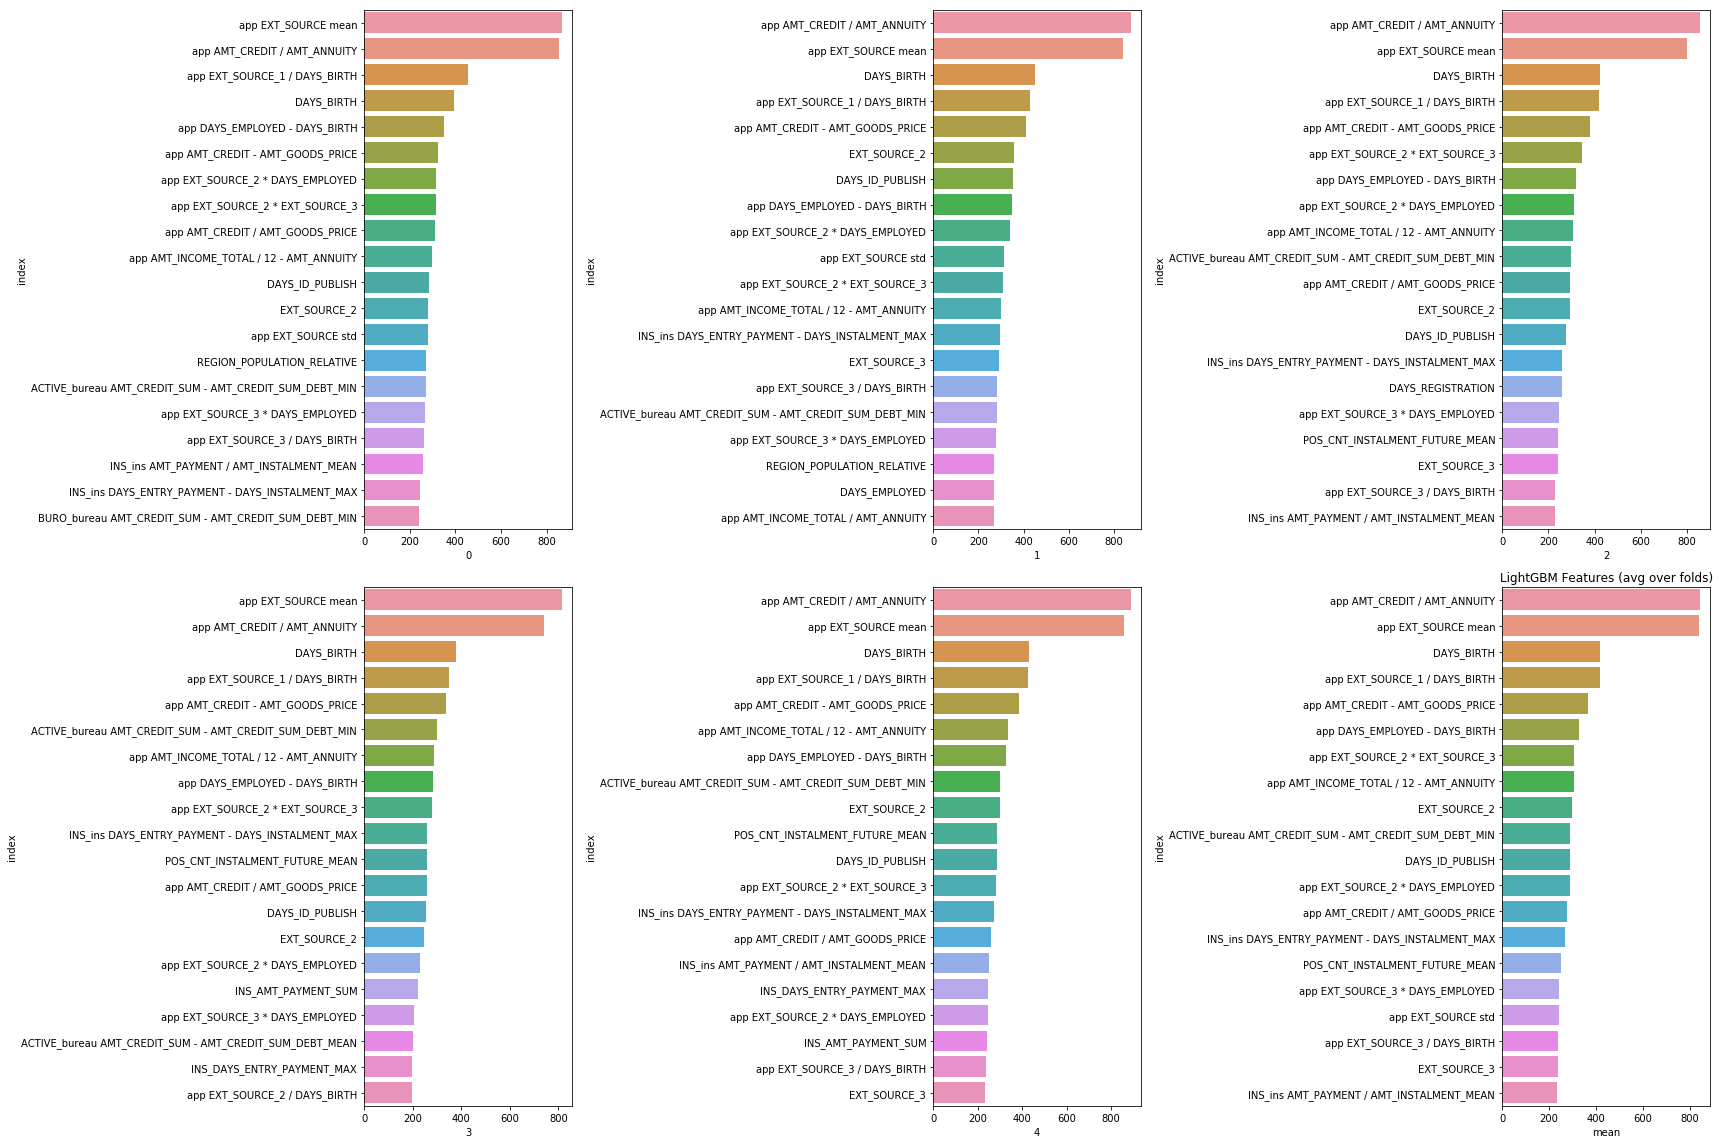

In [28]:
display_folds_importances(feature_importance)

In [29]:
feature_importance[feature_importance['mean'] == 0].shape

(92, 6)

In [31]:
feature_importance.sort_values('mean', ascending = False).head(100)

,0,1,2,3,4,mean
app AMT_CREDIT / AMT_ANNUITY,857,875,856,741,891,844.0
app EXT_SOURCE mean,869,839,800,816,860,836.8
DAYS_BIRTH,396,451,424,377,432,416.0
app EXT_SOURCE_1 / DAYS_BIRTH,454,427,418,351,427,415.4
app AMT_CREDIT - AMT_GOODS_PRICE,324,410,379,336,386,367.0
app DAYS_EMPLOYED - DAYS_BIRTH,350,347,321,283,328,325.8
app EXT_SOURCE_2 * EXT_SOURCE_3,314,308,347,280,283,306.4
app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY,299,300,306,289,336,306.0
EXT_SOURCE_2,282,357,293,247,299,295.6
ACTIVE_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT_MIN,270,281,296,302,300,289.8


### New Bayesian Optimization

In [32]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = LGBMClassifier(**params, n_estimators = 10000, nthread = 4)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]

    folds = KFold(n_splits = 2, shuffle = True, random_state = 1001)
        
    test_pred_proba = np.zeros(train_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = False, early_stopping_rounds = 100)

        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    return roc_auc_score(train_df['TARGET'], test_pred_proba)

In [47]:
params = {'colsample_bytree': (0.8, 1),
          'learning_rate': (.01, .02), 
          'num_leaves': (33, 35), 
          'subsample': (0.8, 1), 
          'max_depth': (7, 9), 
          'reg_alpha': (.03, .05), 
          'reg_lambda': (.06, .08), 
          'min_split_gain': (.01, .03),
          'min_child_weight': (38, 40)
         #'nthread': (15,15)
         }
bo = BayesianOptimization(lgbm_evaluate, params)
bo.maximize(init_points = 5, n_iter = 5)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   num_leaves |   reg_alpha |   reg_lambda |   subsample | 
    1 | 19m31s |    0.78977 |             0.9434 |          0.0176 |      7.4952 |            39.6656 |           0.0206 |      34.2736 |      0.0413 |       0.0798 |      0.8383 | 
    2 | 31m36s |    0.78970 |             0.8370 |          0.0117 |      8.7555 |            39.3013 |           0.0171 |      34.0572 |      0.0361 |       0.0639 |      0.9811 | 
    3 | 30m05s |    0.79045 |             0.8538 |          0.0123 |      8.5318 |            39.2110 |           0.0245 |      33.2526 |      0.0387 |       0.0713 |      0.8438 | 
    4 | 27m47s |    0.79017 |             0.9097 |          0.0142 |      7.

In [48]:
best_params = bo.res['max']['max_params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])

best_params

{'colsample_bytree': 0.8048730486027864,
 'learning_rate': 0.01484731942601113,
 'num_leaves': 33,
 'subsample': 0.8012463270577017,
 'max_depth': 7,
 'reg_alpha': 0.03142444486870515,
 'reg_lambda': 0.07542438011201537,
 'min_split_gain': 0.010446612626924897,
 'min_child_weight': 38.01099642644794}

In [49]:
bo.res['max']['max_val']

0.7904816226770006

In [50]:
feature_importance, scor = cv_scores(df, 5, best_params, test_prediction_file_name = 'prediction_1.csv')

Starting LightGBM. Train shape: (307500, 1505), test shape: (48744, 1505)
Fold 0 started at Thu Aug  9 08:55:04 2018
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.757261	valid_1's auc: 0.748131
Fold  0 AUC : 0.748131
Fold 1 started at Thu Aug  9 08:56:43 2018
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.758305	valid_1's auc: 0.751836
Fold  1 AUC : 0.751836
Fold 2 started at Thu Aug  9 08:58:23 2018
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.759896	valid_1's auc: 0.745174
Fold  2 AUC : 0.745174
Fold 3 started at Thu Aug  9 09:00:02 2018
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.757115	valid_1's auc: 0.744629
Fold  3 AUC : 0.74462

In [51]:
step = 'Bayesian optimization for new set'
scores[step] = scor
scores.loc['LB', step] = .797
scores.T

,roc_auc_train,roc_auc_test,precision_train_0,precision_test_0,precision_train_1,precision_test_1,recall_train_0,recall_test_0,recall_train_1,recall_test_1,LB
Tilii`s Bayesian optimization,0.898163,0.793635,0.928706,0.923431,0.882024,0.558657,0.998507,0.995861,0.127100,0.059662,0.797
Bayesian optimization for new set,0.757676,0.747541,0.919409,0.919362,0.937500,0.789474,0.999989,0.999972,0.001813,0.001209,0.797


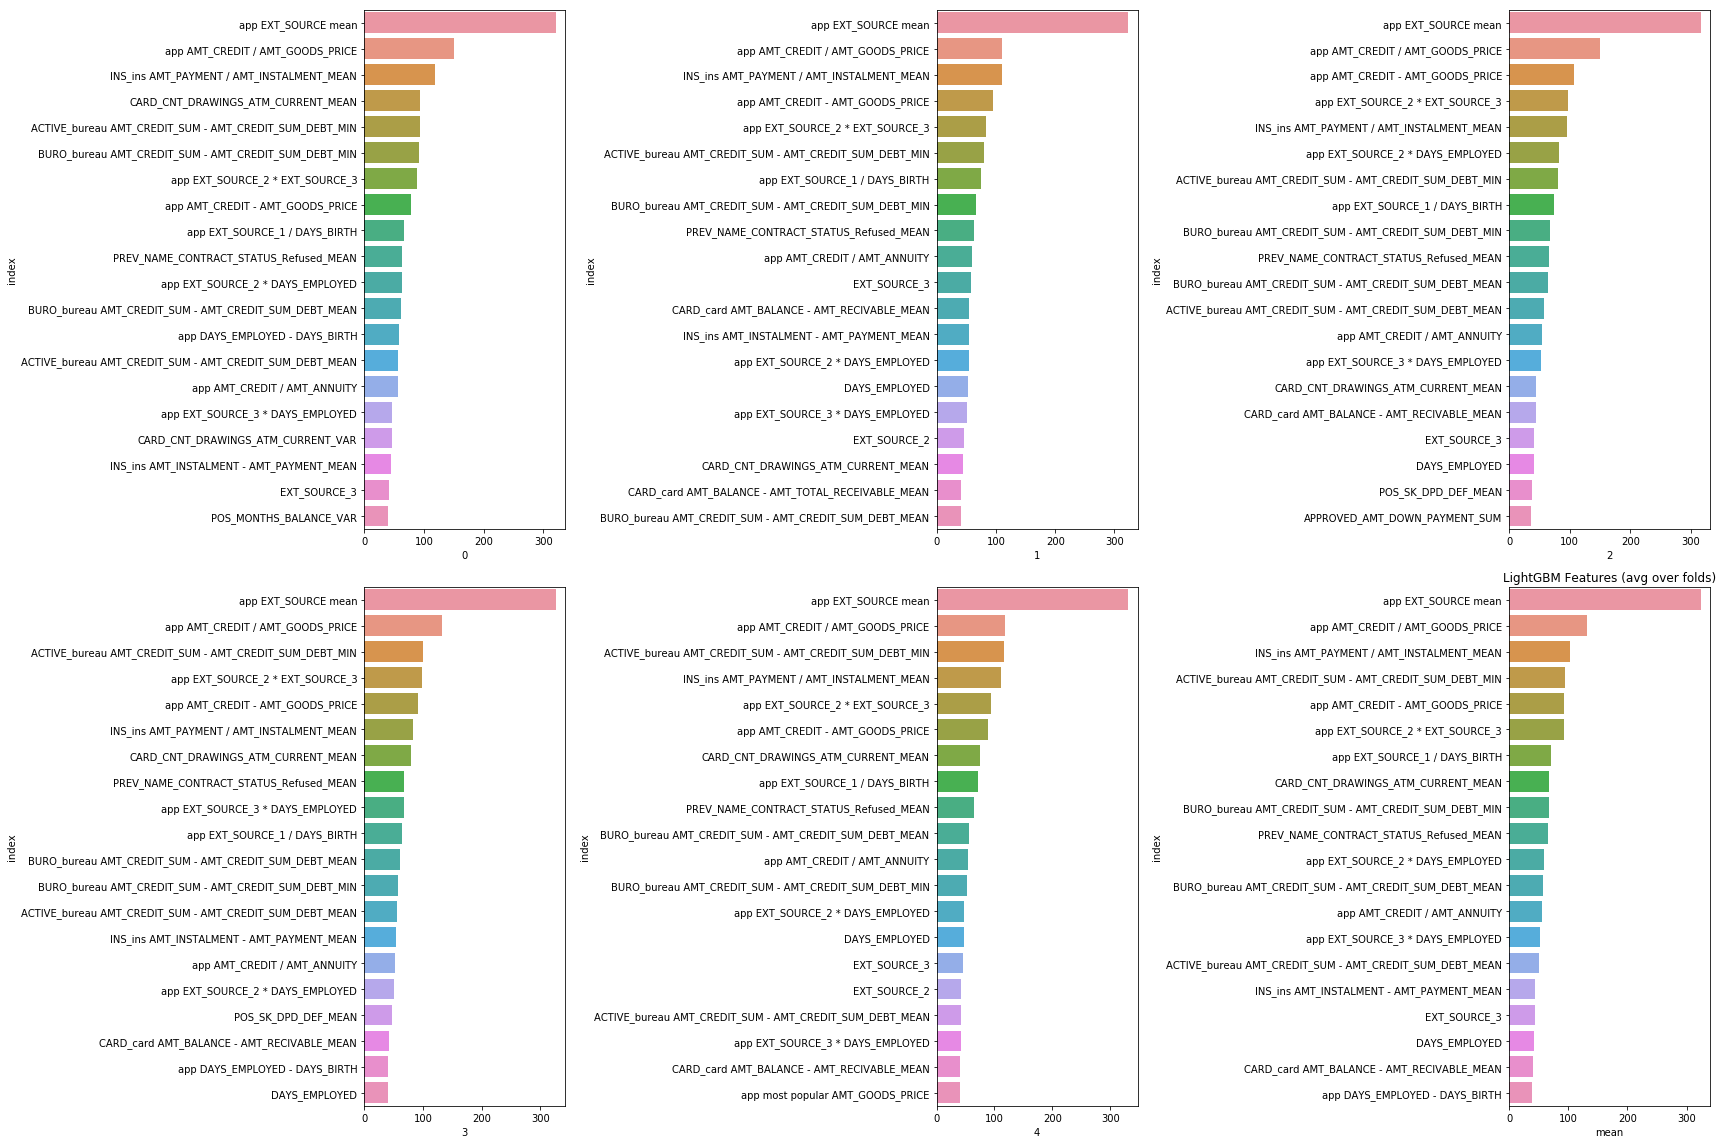

In [52]:
display_folds_importances(feature_importance)

In [53]:
feature_importance[feature_importance['mean'] == 0].shape

(785, 6)

In [54]:
feature_importance.sort_values('mean', ascending = False).head(200)                                                             

,0,1,2,3,4,mean
app EXT_SOURCE mean,321,323,316,326,331,323.4
app AMT_CREDIT / AMT_GOODS_PRICE,151,111,150,132,118,132.4
INS_ins AMT_PAYMENT / AMT_INSTALMENT_MEAN,118,110,96,83,111,103.6
ACTIVE_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT_MIN,93,80,81,100,117,94.2
app AMT_CREDIT - AMT_GOODS_PRICE,79,95,107,92,89,92.4
app EXT_SOURCE_2 * EXT_SOURCE_3,88,83,97,99,94,92.2
app EXT_SOURCE_1 / DAYS_BIRTH,67,75,75,65,72,70.8
CARD_CNT_DRAWINGS_ATM_CURRENT_MEAN,93,45,45,80,75,67.6
BURO_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT_MIN,92,67,68,57,53,67.4
PREV_NAME_CONTRACT_STATUS_Refused_MEAN,64,63,66,68,65,65.2
